In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#train_df = pd.read_csv("Apr-05-2021.csv", index_col=0)
train_df = pd.read_csv("server3_processed.csv")
train_df.head()

Implementation    Mode                           TestName  Status  \
0          quant  server  quic_server_test_connection_close     NaN   
1        quic-go  server  quic_server_test_connection_close     NaN   
2        quic-go  server  quic_server_test_connection_close     NaN   
3        quic-go  server  quic_server_test_connection_close     NaN   
4        quic-go  server  quic_server_test_connection_close     NaN   

                  ErrorIEV                                         OutputFile  \
0  Handshake not completed  /results/temp/355/quic_server_test_connection_...   
1  Handshake not completed  /results/temp/405/quic_server_test_connection_...   
2  Handshake not completed  /results/temp/406/quic_server_test_connection_...   
3  Handshake not completed  /results/temp/456/quic_server_test_connection_...   
4  Handshake not completed  /results/temp/457/quic_server_test_connection_...   

   NbPktSend  isPass  
0       15.0     0.0  
1       16.0     0.0  
2       10.0     0.0  
3       17.0     0.0  
4        7.0     0.0

In [8]:
#       ['quic_server_test_stream', 'quic_server_test_unkown',
#       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
#       'quic_server_test_token_error', 'quic_server_test_tp_error',
#       'quic_server_test_tp_acticoid_error',
#       'quic_server_test_connection_close',
#       'quic_server_test_reset_stream',
#       'quic_server_test_handshake_done_error',
#       'quic_server_test_stop_sending',
#       'quic_server_test_double_tp_error',
#       'quic_server_test_tp_limit_acticoid_error',
#       'quic_server_test_no_icid', 'quic_server_test_ext_min_ack_delay']

for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")
        
train_df = train_df[train_df.Mode != 'client']
train_df = train_df[train_df.TestName != 'quic_server_test_stream']
train_df = train_df[train_df.TestName != 'quic_server_test_unkown']
train_df = train_df[train_df.TestName != 'quic_server_test_tp_limit_newcoid']
train_df = train_df[train_df.TestName != 'quic_server_test_max']
train_df = train_df[train_df.TestName != 'quic_server_test_token_error']
train_df = train_df[train_df.TestName != 'quic_server_test_tp_error']
train_df = train_df[train_df.TestName != 'quic_server_test_tp_acticoid_error']
train_df = train_df[train_df.TestName != 'quic_server_test_reset_stream']
train_df = train_df[train_df.TestName != 'quic_server_test_handshake_done_error']
train_df = train_df[train_df.TestName != 'quic_server_test_stop_sending']
train_df = train_df[train_df.TestName != 'quic_server_test_double_tp_error']
train_df = train_df[train_df.TestName != 'quic_server_test_double_tp_error']
train_df = train_df[train_df.TestName != 'quic_server_test_tp_limit_acticoid_error']
train_df = train_df[train_df.TestName != 'quic_server_test_ext_min_ack_delay']
train_df.head()

Implementation    Mode  \
Run                                                              
2     ./server -d . -c /QUIC-Ivy/doc/examples/quic/...  server   
5     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
8     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
11    ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
14    ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   

                              TestName  Status                ErrorIEV  \
Run                                                                      
2    quic_server_test_connection_close     NaN  ivy_return_code(1)+"")   
5    quic_server_test_connection_close     NaN  ivy_return_code(1)+"")   
8    quic_server_test_connection_close     NaN  ivy_return_code(1)+"")   
11   quic_server_test_connection_close     NaN  ivy_return_code(1)+"")   
14   quic_server_test_connection_close     NaN  ivy_return_code(1)+"")   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
2    /results/temp/355/quic_server_test_connection_...        0.0     0.0  
5    /results/temp/405/quic_server_test_connection_...        0.0     0.0  
8    /results/temp/406/quic_server_test_connection_...        0.0     0.0  
11   /results/temp/456/quic_server_test_connection_...        0.0     0.0  
14   /results/temp/457/quic_server_test_connection_...        0.0     0.0

In [9]:
server_name = train_df.Implementation.unique()
servers = []
for s in server_name:
    if "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    if "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    if "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    if "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    if "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    if "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    if "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")

print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)



train_df.head()

['quant', 'quic-go', 'aioquic', 'quinn', 'mvfst', 'picoquic']


Implementation    Mode                           TestName  Status  \
Run                                                                     
2            quant  server  quic_server_test_connection_close     NaN   
5          quic-go  server  quic_server_test_connection_close     NaN   
8          quic-go  server  quic_server_test_connection_close     NaN   
11         quic-go  server  quic_server_test_connection_close     NaN   
14         quic-go  server  quic_server_test_connection_close     NaN   

                   ErrorIEV  \
Run                           
2    ivy_return_code(1)+"")   
5    ivy_return_code(1)+"")   
8    ivy_return_code(1)+"")   
11   ivy_return_code(1)+"")   
14   ivy_return_code(1)+"")   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
2    /results/temp/355/quic_server_test_connection_...        0.0     0.0  
5    /results/temp/405/quic_server_test_connection_...        0.0     0.0  
8    /results/temp/406/quic_server_test_connection_...        0.0     0.0  
11   /results/temp/456/quic_server_test_connection_...        0.0     0.0  
14   /results/temp/457/quic_server_test_connection_...        0.0     0.0

In [27]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server-result-3" + row["OutputFile"][8:]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content and not "quic_server_test_connection_close" in resultFile:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(1)+value(" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")

In [28]:
train_df["ErrorIEV"].unique().tolist()

['Handshake not completed',
 'No Error',
 'require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',
 'server_return_code(1)+timeout',
 'Run out of cid',
 'frame.connection_close:{err_code:0xc}',
 'require ~path_challenge_pending(dcid,f.data);"',
 'require dcid = 0;"',
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"',
 'Segmentation Fault 134',
 'require ~is_no_error;"',
 'frame.connection_close:{err_code:0xa}',
 'require conn_total_data(the_cid) > 0;"',
 'require is_no_error"',
 'require is_protocol_violation"',
 'timeout+> client_send_event({protocol:udp,addr:0x7f000001,port:0x137c},{protocol:udp,addr:0x7f000001,port:0x115b},0x841a29c1,0x38,0x1)',
 'server_return_code(-4)+ivy_return_code(1)',
 'require stream_id_allowed(dcid,f.id);  # [4]"']

In [12]:
train_df.TestName.unique()

array(['quic_server_test_connection_close', 'quic_server_test_no_icid',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_accept_maxdata'], dtype=object)

In [14]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i =  row["OutputFile"][outfile.find("/",13)+1:outfile.find("/",14)] 
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "server-result-3/temp/" + str(i) + "_quic_server_" + str(row["TestName"])  + ".pcap"
                packets = rdpcap(resultFile)
                ln = len(packets)
                df.loc[index, "NbPktSend"] = ln
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server3_processed.csv",index=False)
    j += size
    

train_df.head()

4200
420
10



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


Implementation    Mode                           TestName  Status  \
Run                                                                     
2            quant  server  quic_server_test_connection_close     NaN   
5          quic-go  server  quic_server_test_connection_close     NaN   
8          quic-go  server  quic_server_test_connection_close     NaN   
11         quic-go  server  quic_server_test_connection_close     NaN   
14         quic-go  server  quic_server_test_connection_close     NaN   

                    ErrorIEV  \
Run                            
2    Handshake not completed   
5    Handshake not completed   
8    Handshake not completed   
11   Handshake not completed   
14   Handshake not completed   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
2    /results/temp/355/quic_server_test_connection_...       15.0     0.0  
5    /results/temp/405/quic_server_test_connection_...       16.0     0.0  
8    /results/temp/406/quic_server_test_connection_...       10.0     0.0  
11   /results/temp/456/quic_server_test_connection_...       17.0     0.0  
14   /results/temp/457/quic_server_test_connection_...        7.0     0.0

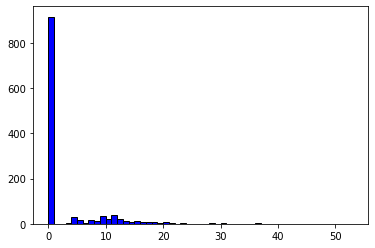

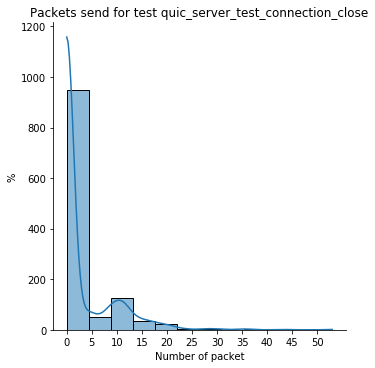

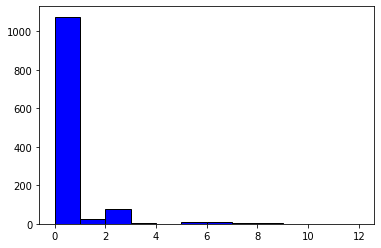

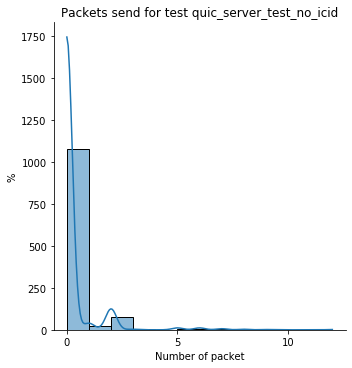

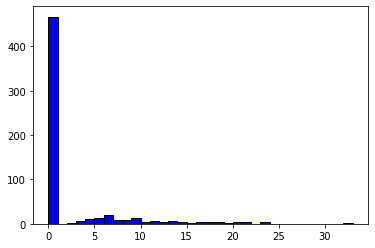

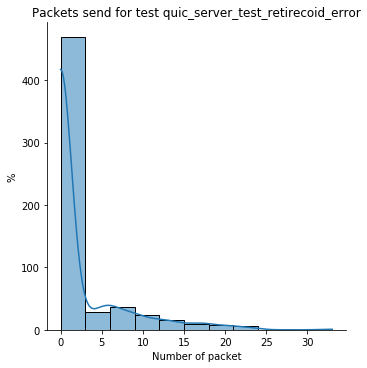

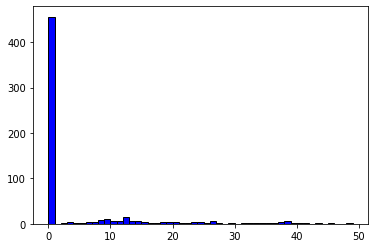

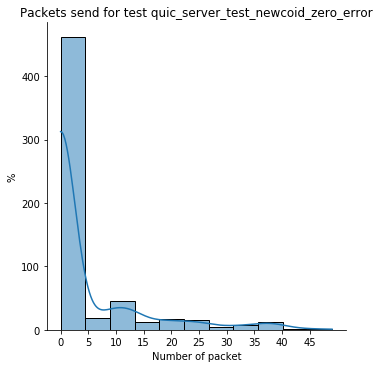

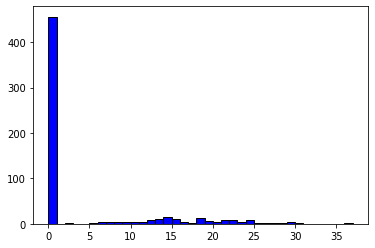

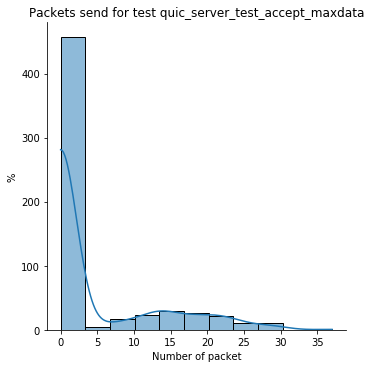

In [16]:
# Failure per test

tests = train_df.TestName.unique()

#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.displot(subdf['NbPktSend'],
                 kde=True)
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('Number of packet')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + '.png'
    plt.savefig(filename)
    plt.show()

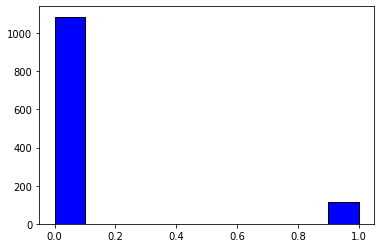

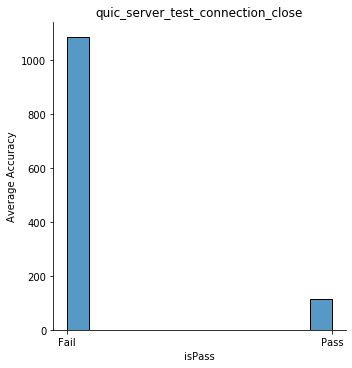

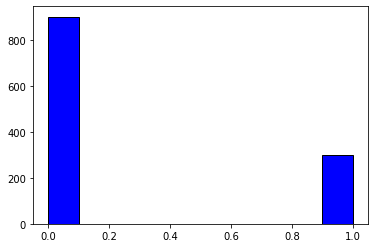

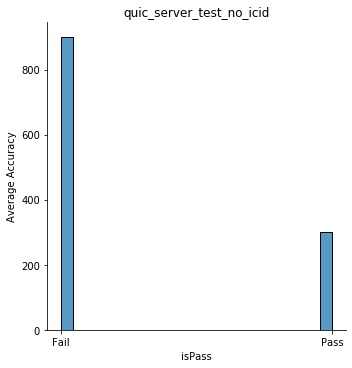

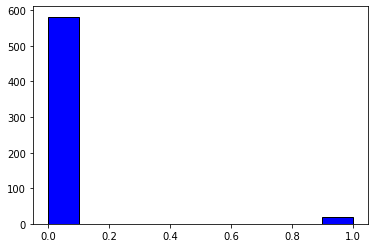

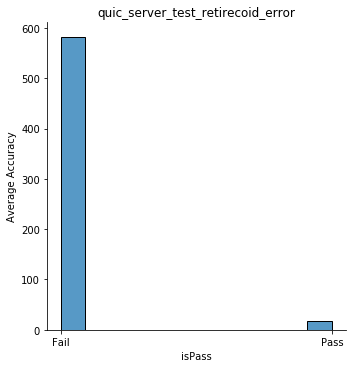

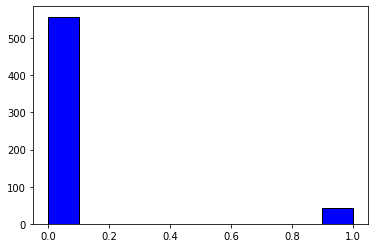

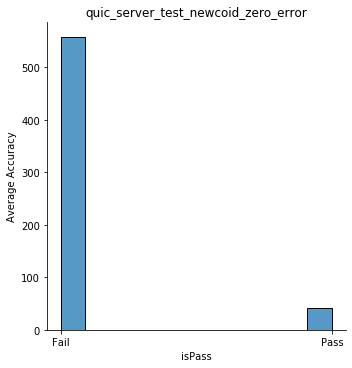

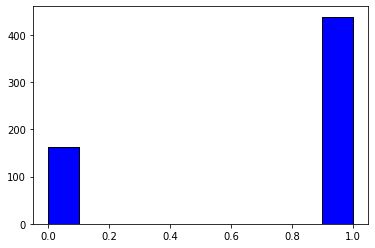

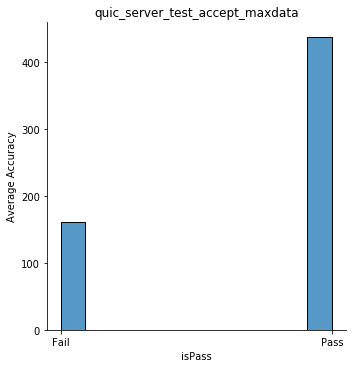

In [29]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()

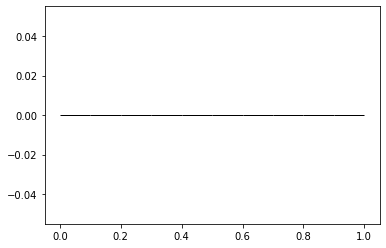

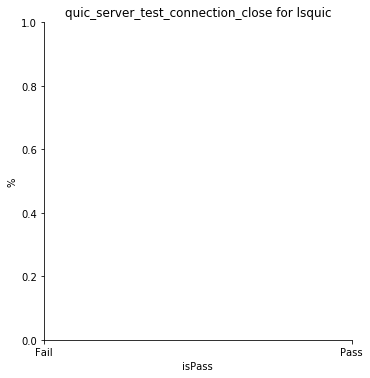

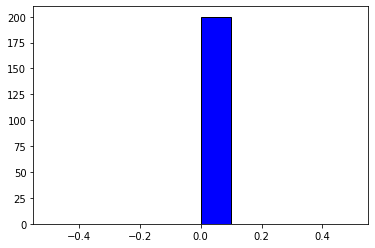

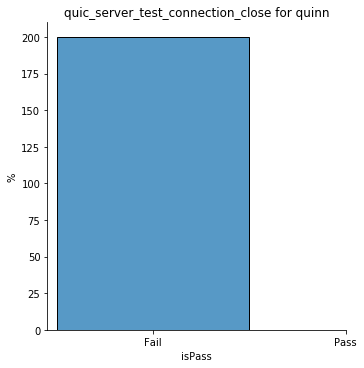

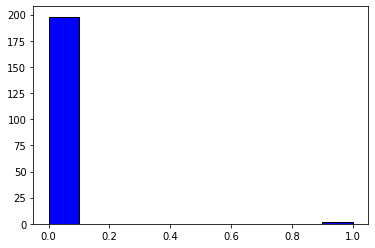

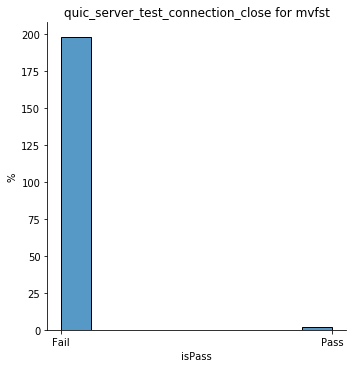

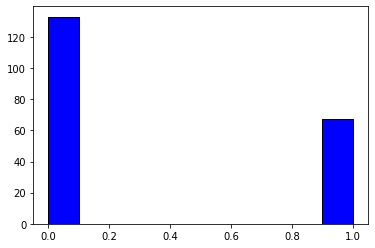

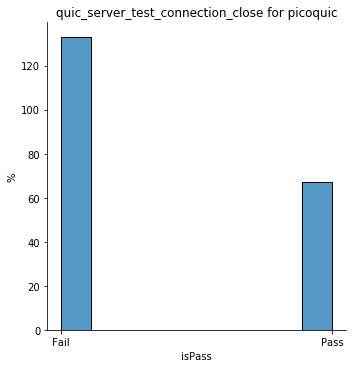

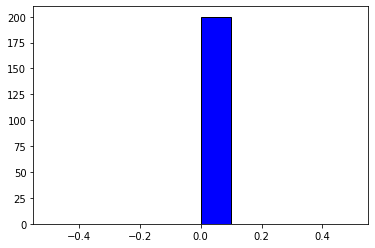

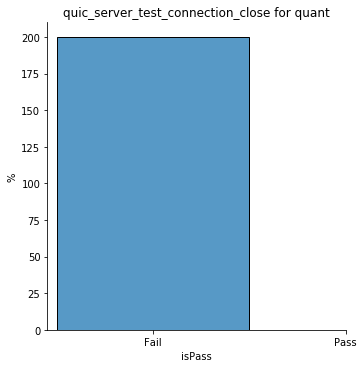

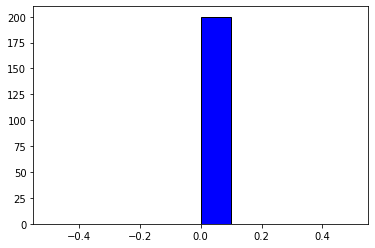

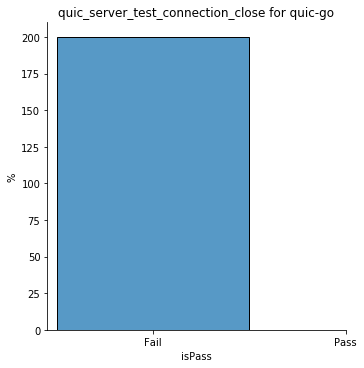

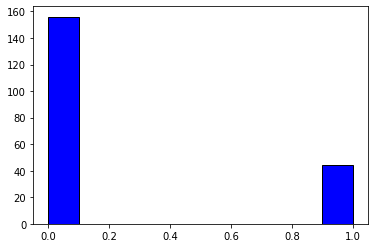

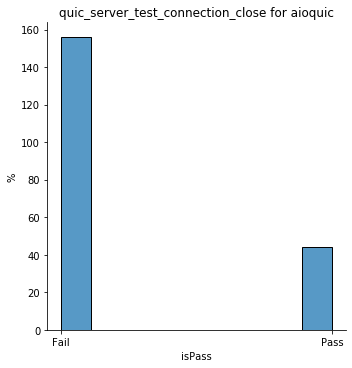

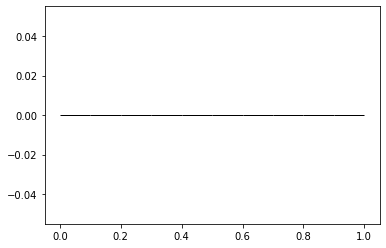

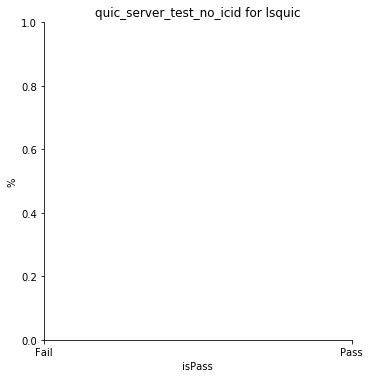

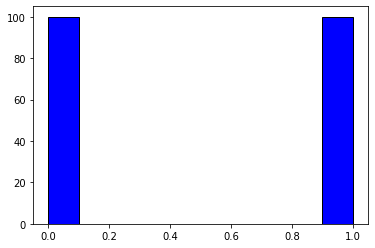

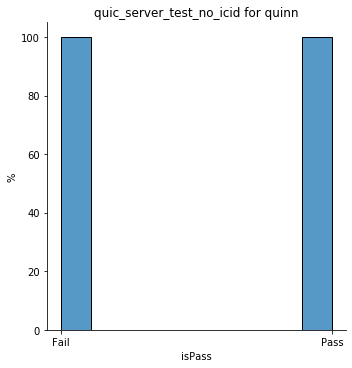

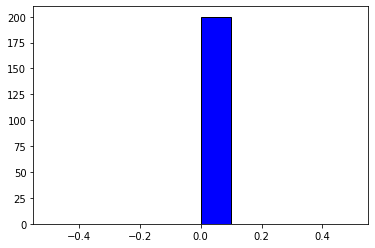

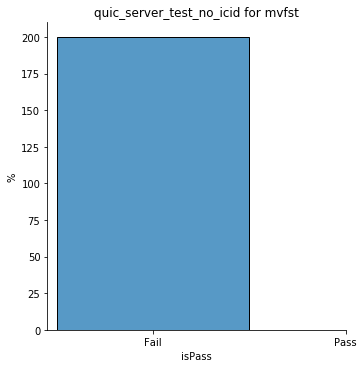

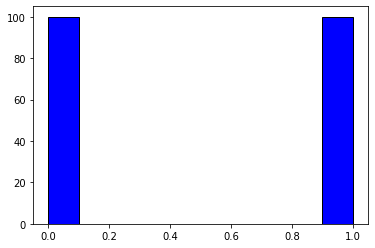

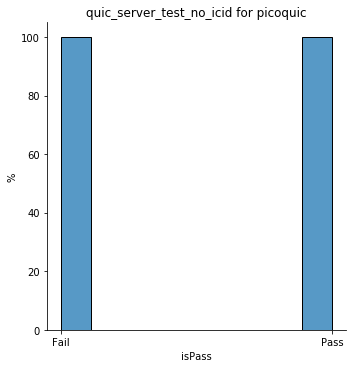

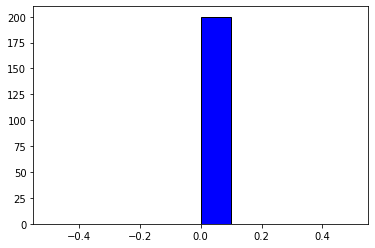

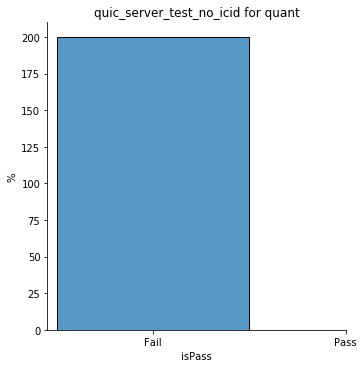

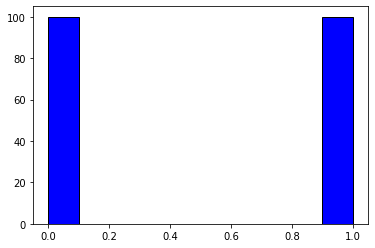

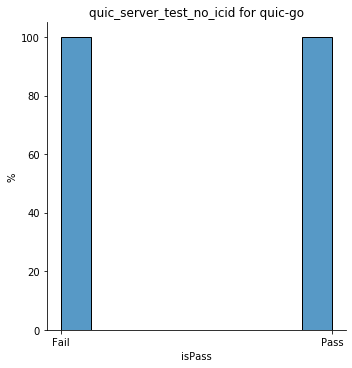

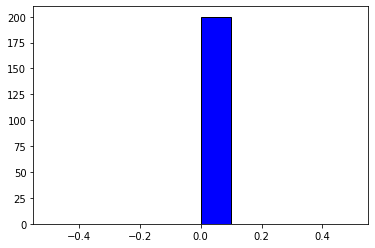

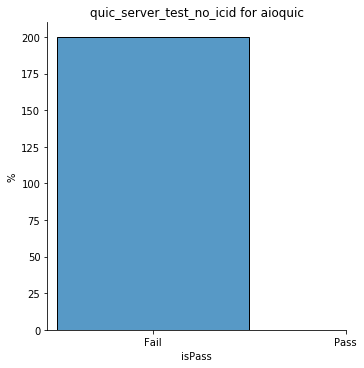

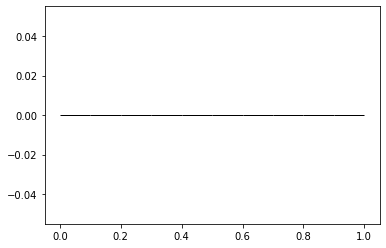

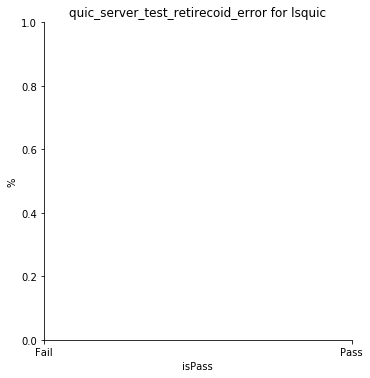

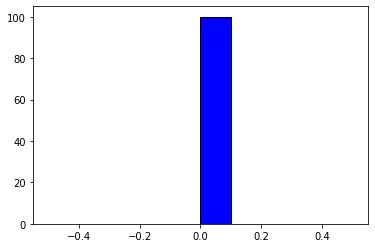

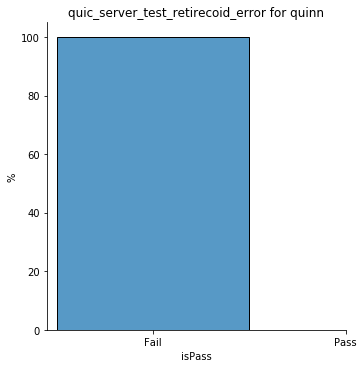

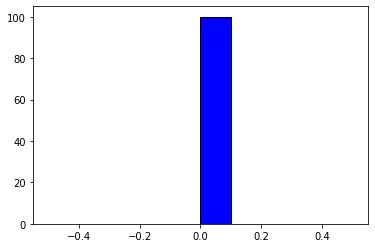

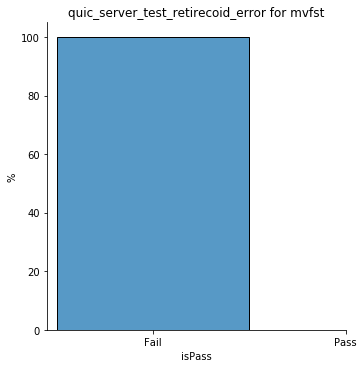

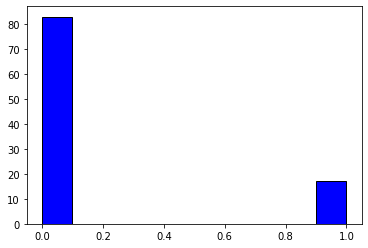

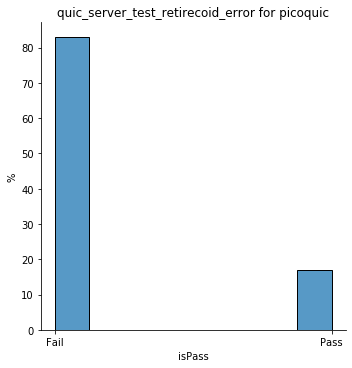

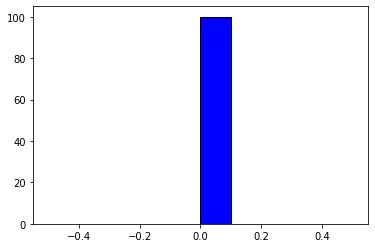

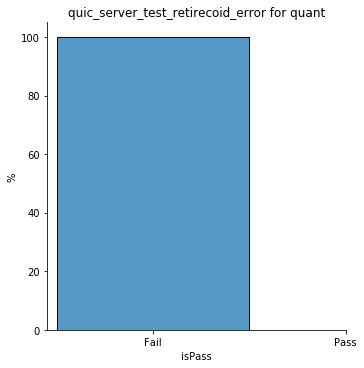

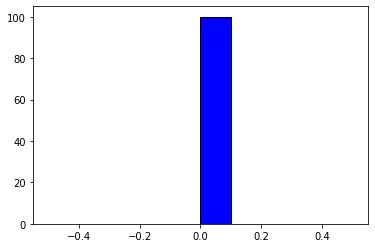

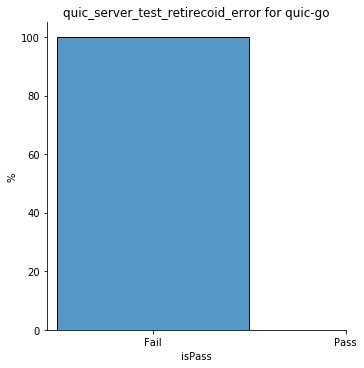

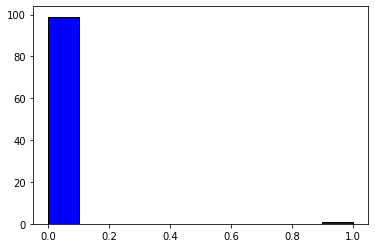

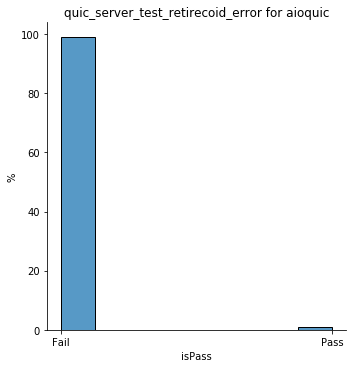

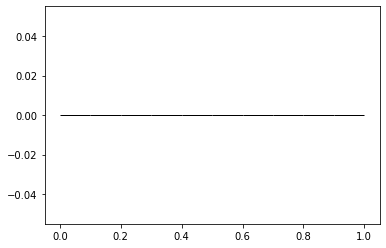

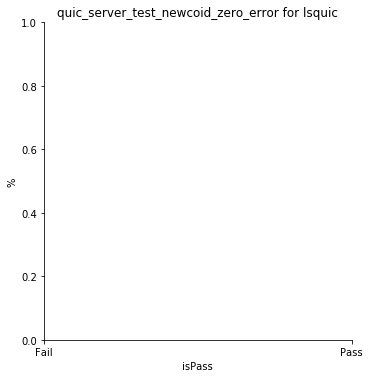

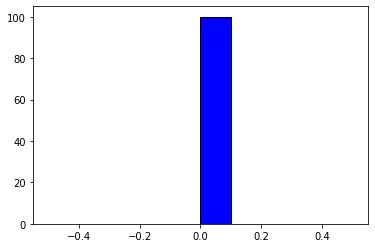

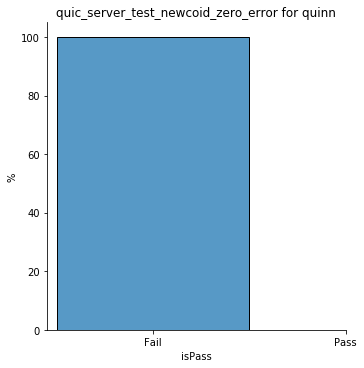

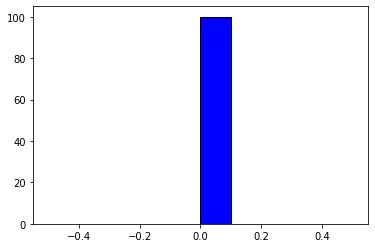

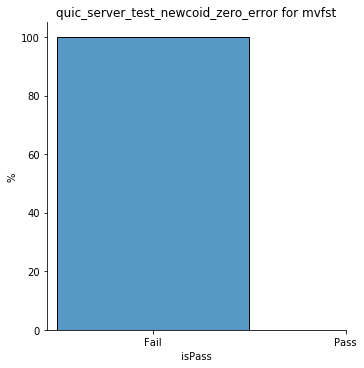

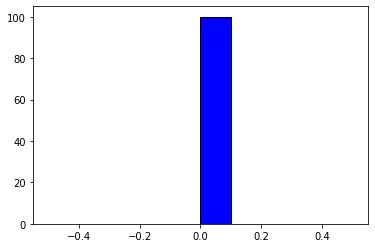

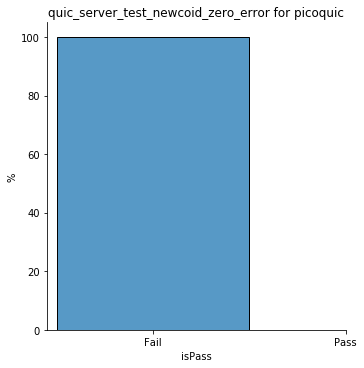

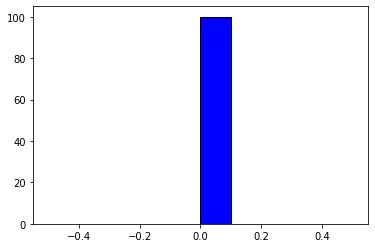

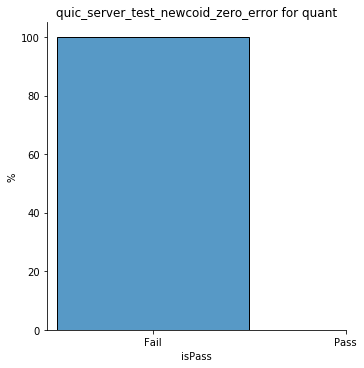

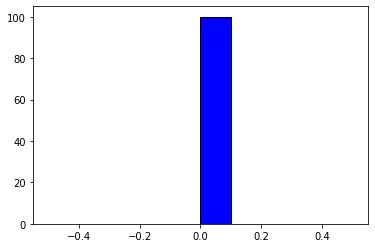

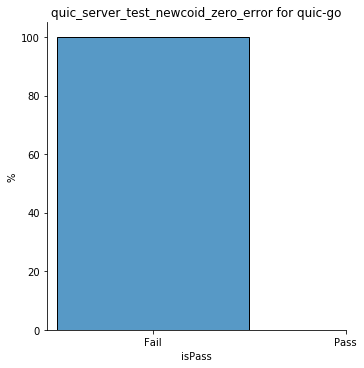

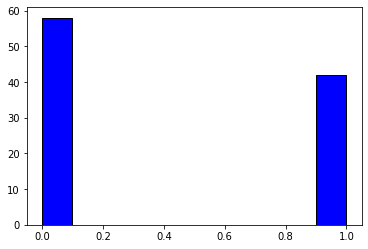

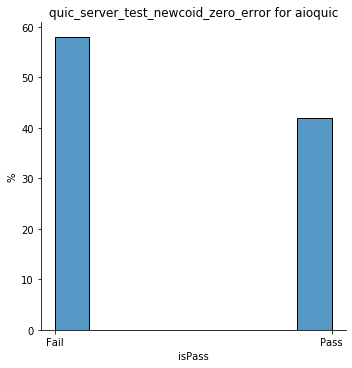

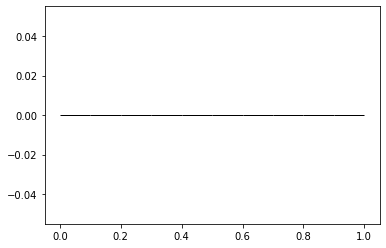

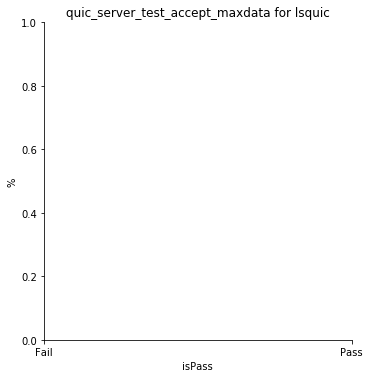

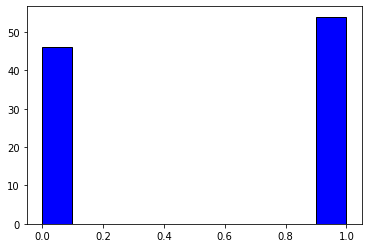

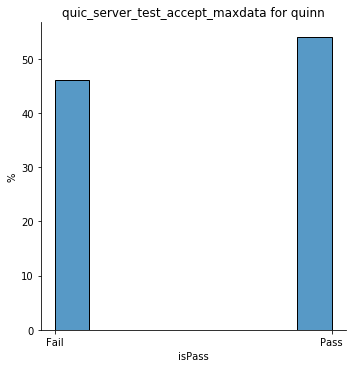

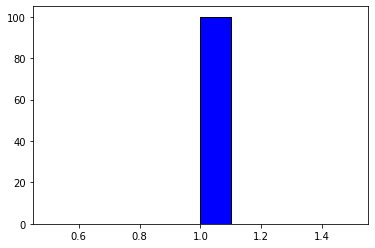

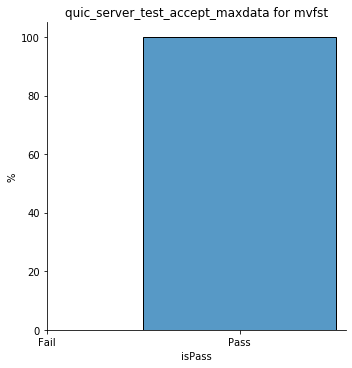

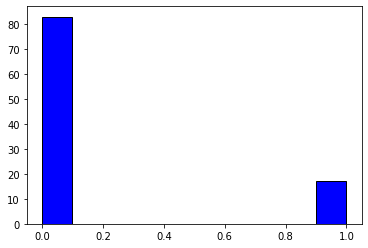

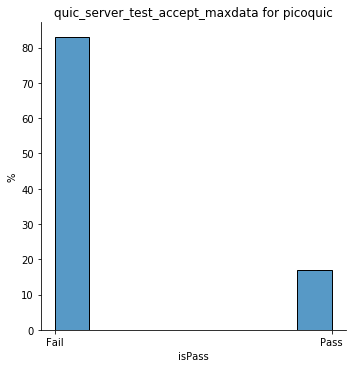

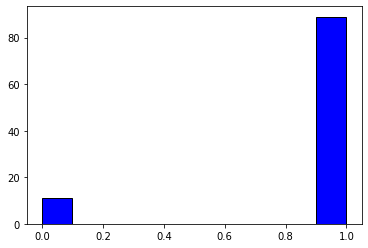

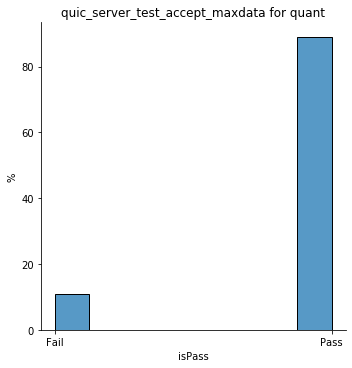

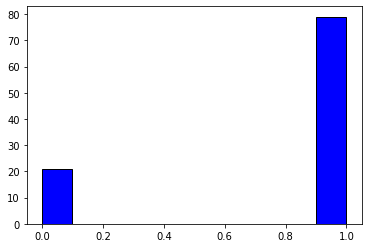

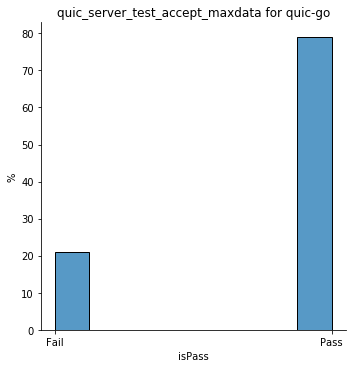

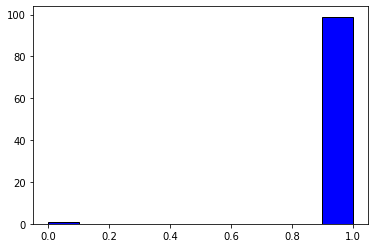

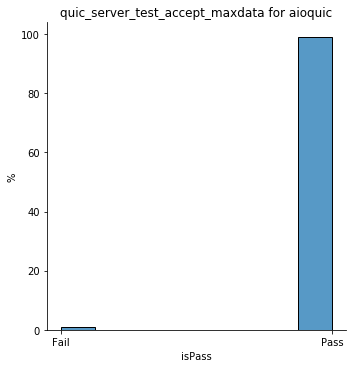

In [30]:
tests = train_df.TestName.unique()

servers = ['lsquic', 'quinn',  'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10]) 'lsquic',
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.displot(subsubdf['isPass'], kde=False)
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + t + "_for_" + s + '.png'
        plt.savefig(filename)

        plt.show()
    

In [19]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

lsquic
0
0.0

quinn
700
154.0

mvfst
700
102.0

picoquic
700
201.0

quant
700
89.0

quic-go
700
179.0

aioquic
700
186.0



In [34]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    for s in tests:
        ssubdf = subdf.loc[subdf['TestName'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

lsquic
quic_server_test_connection_close
0
0.0

lsquic
quic_server_test_no_icid
0
0.0

lsquic
quic_server_test_retirecoid_error
0
0.0

lsquic
quic_server_test_newcoid_zero_error
0
0.0

lsquic
quic_server_test_accept_maxdata
0
0.0

quinn
quic_server_test_connection_close
200
0.0

quinn
quic_server_test_no_icid
100
100.0

quinn
quic_server_test_retirecoid_error
100
0.0

quinn
quic_server_test_newcoid_zero_error
100
0.0

quinn
quic_server_test_accept_maxdata
100
54.0

mvfst
quic_server_test_connection_close
200
2.0

mvfst
quic_server_test_no_icid
0
0.0

mvfst
quic_server_test_retirecoid_error
100
0.0

mvfst
quic_server_test_newcoid_zero_error
100
0.0

mvfst
quic_server_test_accept_maxdata
100
100.0

picoquic
quic_server_test_connection_close
200
67.0

picoquic
quic_server_test_no_icid
100
100.0

picoquic
quic_server_test_retirecoid_error
100
17.0

picoquic
quic_server_test_newcoid_zero_error
100
0.0

picoquic
quic_server_test_accept_maxdata
100
17.0

quant
quic_server_test_connection_clos

quic_server_test_connection_close
lsquic
[]


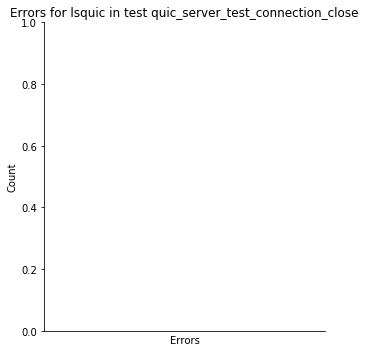

quic_server_test_no_icid
lsquic
[]


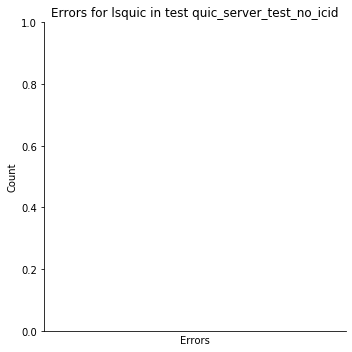

quic_server_test_retirecoid_error
lsquic
[]


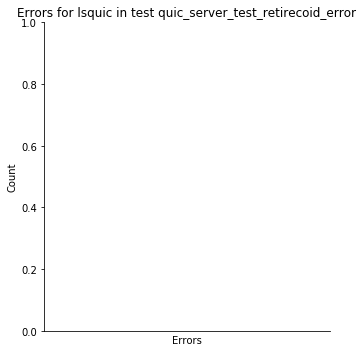

quic_server_test_newcoid_zero_error
lsquic
[]


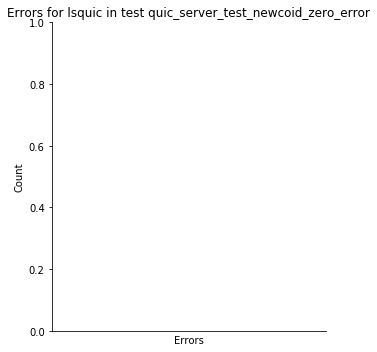

quic_server_test_accept_maxdata
lsquic
[]


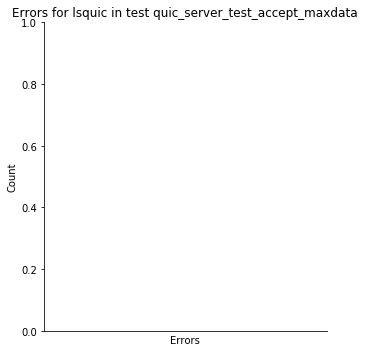

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
quinn
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"']


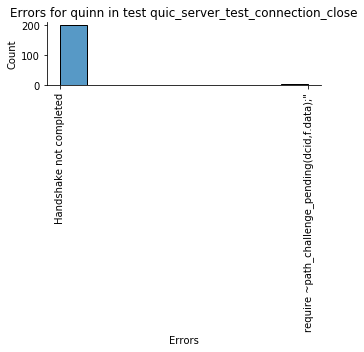

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_no_icid
quinn
['No Error']


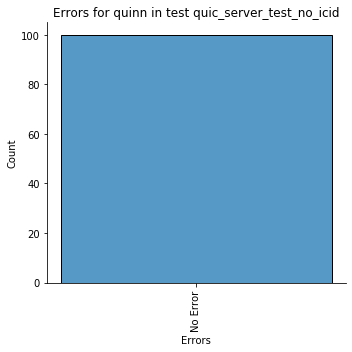

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_retirecoid_error
quinn
['Run out of cid', 'Handshake not completed', 'server_return_code(-4)+ivy_return_code(1)']


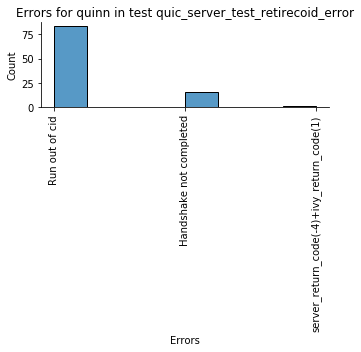

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_newcoid_zero_error
quinn
['require ~path_challenge_pending(dcid,f.data);"', 'require dcid = 0;"', 'Handshake not completed']


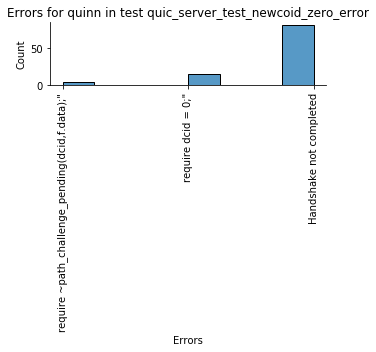

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_accept_maxdata
quinn
['No Error', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed']


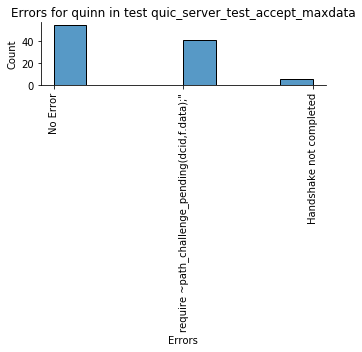

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
mvfst
['Handshake not completed', 'No Error', 'require is_no_error"']


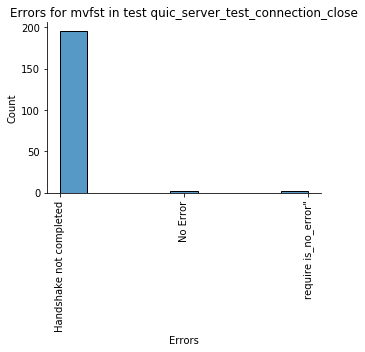

quic_server_test_no_icid
mvfst
[]


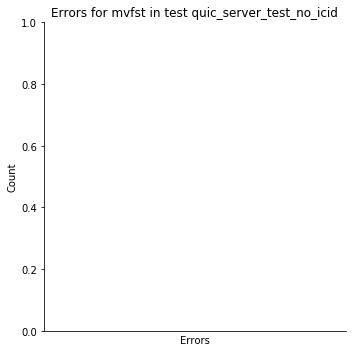

quic_server_test_retirecoid_error
mvfst
['Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Run out of cid']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


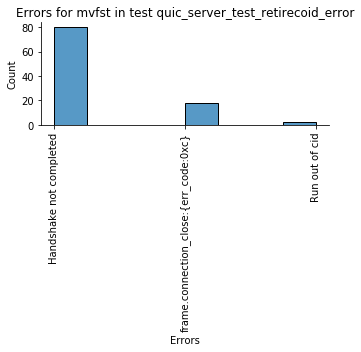

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_newcoid_zero_error
mvfst
['Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'require dcid = 0;"', 'Segmentation Fault 134']


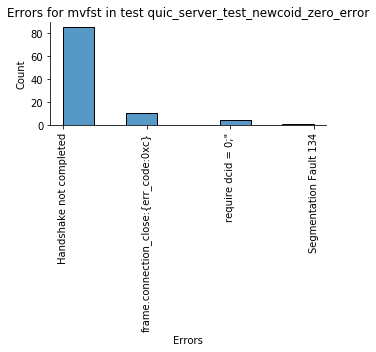

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_accept_maxdata
mvfst
['No Error']


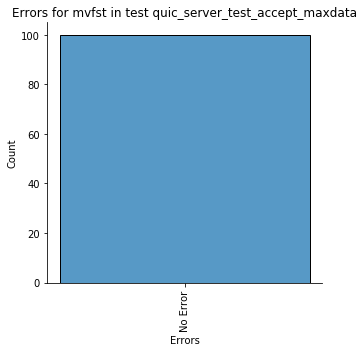

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_connection_close
picoquic
['No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


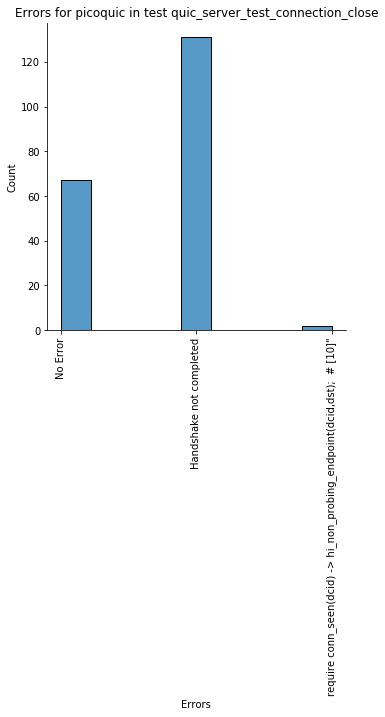

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_no_icid
picoquic
['No Error']


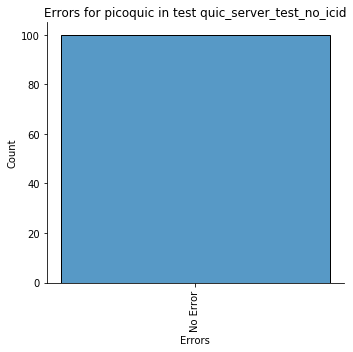

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_retirecoid_error
picoquic
['Run out of cid', 'Handshake not completed', 'frame.connection_close:{err_code:0xa}', 'No Error']


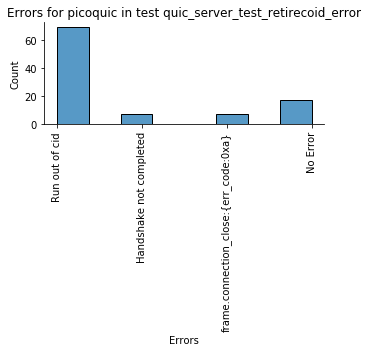

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_newcoid_zero_error
picoquic
['Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require dcid = 0;"', 'require is_protocol_violation"']


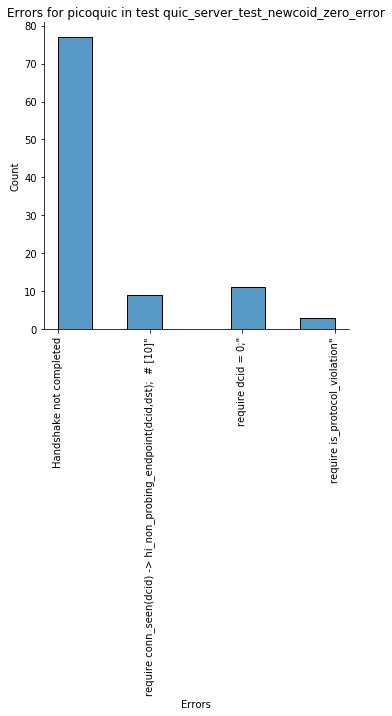

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_accept_maxdata
picoquic
['require ~is_no_error;"', 'No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require stream_id_allowed(dcid,f.id);  # [4]"']


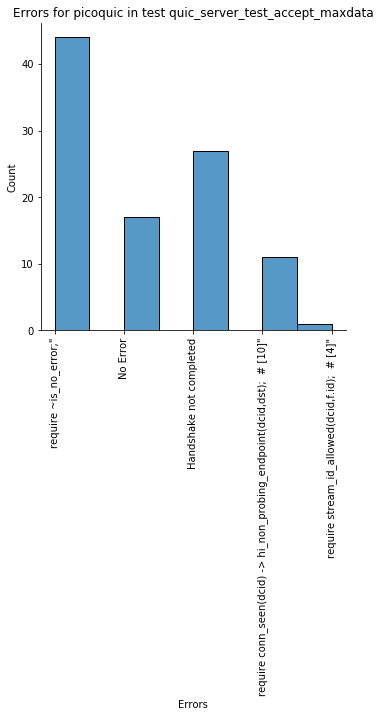

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
quant
['Handshake not completed', 'Segmentation Fault 134']


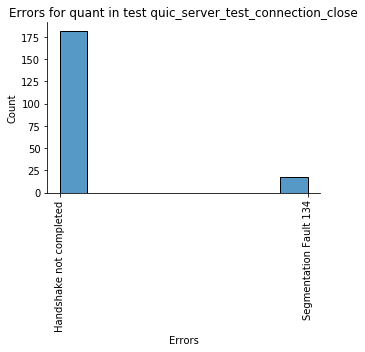

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_no_icid
quant
['server_return_code(1)+timeout']


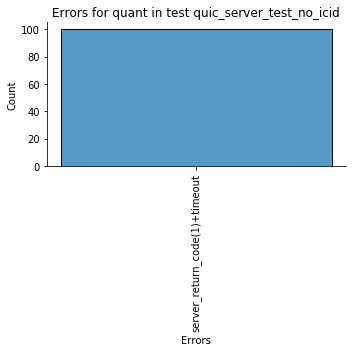

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_retirecoid_error
quant
['Handshake not completed', 'Segmentation Fault 134']


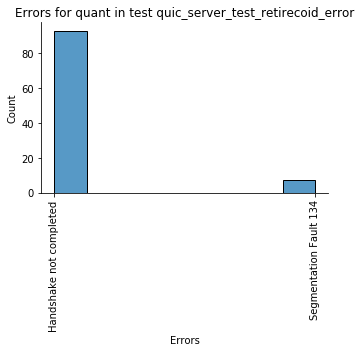

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_newcoid_zero_error
quant
['Handshake not completed', 'Segmentation Fault 134']


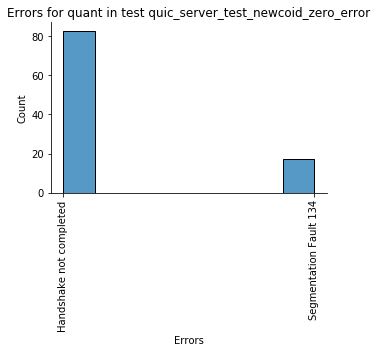

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_accept_maxdata
quant
['No Error', 'Segmentation Fault 134']


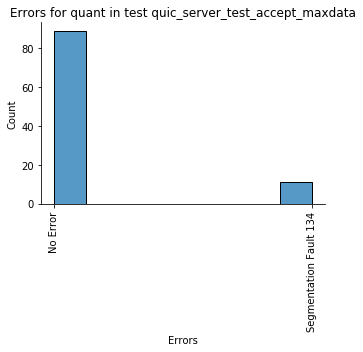

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
quic-go
['Handshake not completed']


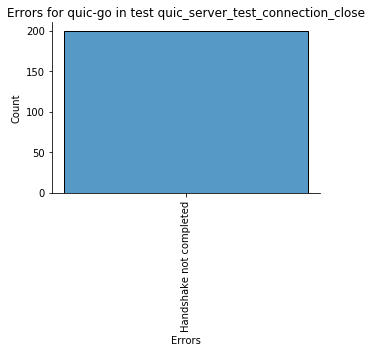

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_no_icid
quic-go
['No Error']


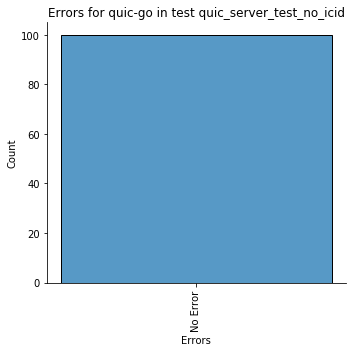

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_retirecoid_error
quic-go
['Handshake not completed']


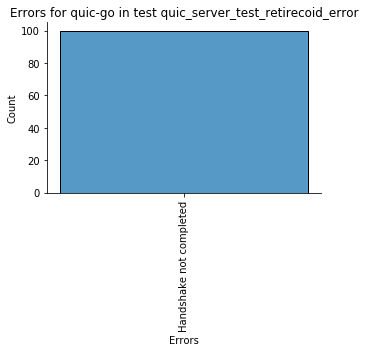

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_newcoid_zero_error
quic-go
['Handshake not completed']


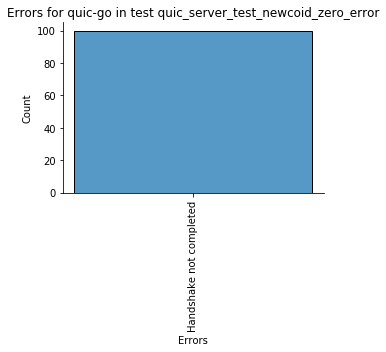

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_accept_maxdata
quic-go
['No Error', 'Handshake not completed', 'timeout+> client_send_event({protocol:udp,addr:0x7f000001,port:0x137c},{protocol:udp,addr:0x7f000001,port:0x115b},0x841a29c1,0x38,0x1)']


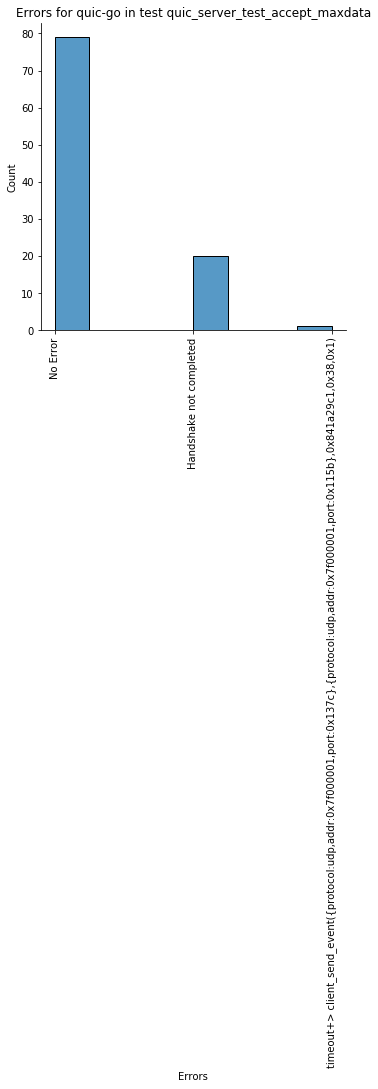

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
aioquic
['No Error', 'Handshake not completed', 'require conn_total_data(the_cid) > 0;"', 'require is_no_error"']


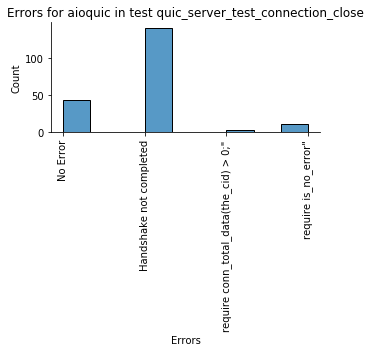

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_no_icid
aioquic
['Run out of cid', 'Handshake not completed']


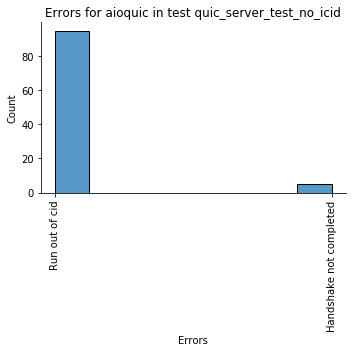

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_retirecoid_error
aioquic
['Run out of cid', 'Handshake not completed', 'No Error', 'Segmentation Fault 134']


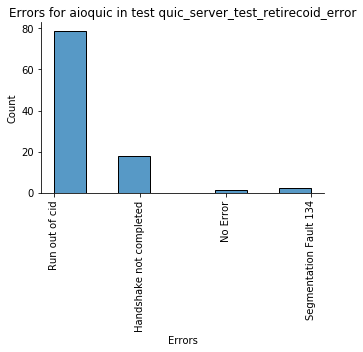

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_newcoid_zero_error
aioquic
['No Error', 'require dcid = 0;"', 'Handshake not completed', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


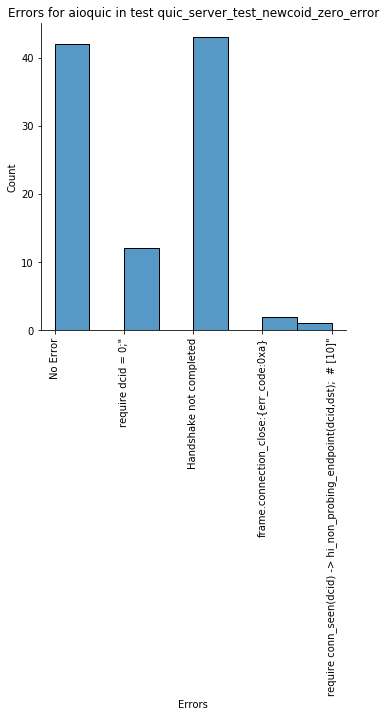

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


quic_server_test_accept_maxdata
aioquic
['No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


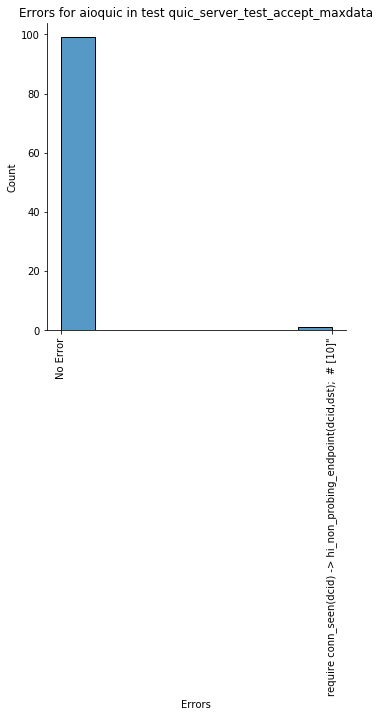

In [33]:
all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for s in servers:
    subdf = train_df.loc[train_df['Implementation'] == s]
    for t in tests:
        subsubdf = subdf.loc[subdf['TestName'] == t]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
                
        # seaborn histogram
        sns.displot(x=subsubdf['ErrorsCode'],  kde=False ) #,hue="Implementation"
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=90)  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        fig = plt.gcf()
        plt.tight_layout()
        #fig.set_size_inches(20,20)
        plt.savefig(filename, dpi=fig.dpi*2)
        plt.show()

In [32]:
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_no_icid':
        if 'require initial_source_connection_id.is_set(trans_params(scid));  # [5]"' in row["ErrorIEV"]:
            train_df.drop(i,0,inplace=True)

In [5]:
#subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_stream']
subsubdf = train_df.loc[train_df['Implementation'] == 'quic-go']
#print(subsubdf.loc[subsubdf["ErrorIEV"] == 'require is_frame_encoding_error;"'])
print(subsubdf.loc[subsubdf['TestName'] == 'quic_server_test_accept_maxdata'])

     Implementation    Mode                         TestName  Status  \
115         quic-go  server  quic_server_test_accept_maxdata     NaN   
116         quic-go  server  quic_server_test_accept_maxdata     NaN   
117         quic-go  server  quic_server_test_accept_maxdata     NaN   
118         quic-go  server  quic_server_test_accept_maxdata     NaN   
222         quic-go  server  quic_server_test_accept_maxdata     NaN   
223         quic-go  server  quic_server_test_accept_maxdata     NaN   
298         quic-go  server  quic_server_test_accept_maxdata     NaN   
302         quic-go  server  quic_server_test_accept_maxdata     NaN   
382         quic-go  server  quic_server_test_accept_maxdata     NaN   
383         quic-go  server  quic_server_test_accept_maxdata     NaN   
424         quic-go  server  quic_server_test_accept_maxdata     NaN   
425         quic-go  server  quic_server_test_accept_maxdata     NaN   
543         quic-go  server  quic_server_test_accept_maxdata    